In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.utils import shuffle

from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("data/combined_df.csv")
df = df[
    (df['Year'] >= 2020) &
    (~(df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
data = df.dropna()

data['Event Date'] = pd.to_datetime(data['Event Date'])
data['day_of_week'] = data['Event Date'].dt.day_of_week
data = data.sort_values(by='Year', ascending=True)
data.head(3)

C:\Users\sarah\AppData\Local\Temp\ipykernel_14968\4120974916.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/combined_df.csv")
C:\Users\sarah\AppData\Local\Temp\ipykernel_14968\4120974916.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Event Date'] = pd.to_datetime(data['Event Date'])
C:\Users\sarah\AppData\Local\Temp\ipykernel_14968\4120974916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da

,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
109068,2020-01-14,Leif Vollebekk,Leif Vollebekk,"['canadian americana', 'indie anthem-folk', 'i...",124552.0,57.0,Leif Vollebekk,UCTX_L3Y3kxW_E3FPRfBUPzg,Leif Vollebekk,Official videos and live performances from Lei...,...,Pop / Rock,472.0,7128.0,472.0,100%,15.0,18.0,15.10,1,1
107394,2020-02-04,The Lumineers,The Lumineers,"['folk-pop', 'modern rock', 'neo mellow', 'sto...",5504019.0,80.0,The Lumineers,UCB7P9Hr5BYB5Mkxau6t3Sgw,The Lumineers,The Lumineers Youtube Channel. \nCheck us out ...,...,Pop / Rock,11427.0,607018.0,11427.0,100%,39.0,89.0,53.12,2,1
107410,2020-02-04,Mat Kearney,Mat Kearney,"['acoustic pop', 'neo mellow']",481873.0,54.0,Mat Kearney,UC5__Uexru2WvNLuDc_v4y2g,Mat Kearney,http://matkearney.os.fan,...,Pop / Rock,974.0,40635.0,974.0,100%,32.5,52.5,41.72,2,1


In [3]:
top_20_markets = data['Market'].value_counts().iloc[:20].index
one_hot_encoded = pd.get_dummies(data['Market'])
one_hot_encoded = one_hot_encoded[top_20_markets]
data = data.join(one_hot_encoded)

## Model 1

In [4]:
features = ['Avg. Event Capacity',
            'Ticket Price Min USD', 
            'Ticket Price Max USD',
            'Year',
            'monthly_listeners',
            'Month',
            'day_of_week'] + list(top_20_markets)

In [5]:
X = data[features]
y = data['Avg. Gross USD']
X = X.dropna()
y = y[X.index]
y = np.log1p(y)

In [6]:
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0)

rkf = RepeatedKFold(n_splits=5, n_repeats=30, random_state=42)

cv_rmse = np.sqrt(-cross_val_score(cat_model, X, y, cv=rkf, scoring='neg_mean_squared_error'))
cv_mae = -cross_val_score(cat_model, X, y, cv=rkf, scoring='neg_mean_absolute_error')
cv_r2 = cross_val_score(cat_model, X, y, cv=rkf, scoring='r2')

print("CatBoost Regressor Cross-Validation Performance:")
print("Cross-Validation RMSE: Mean =", cv_rmse.mean())
print("Cross-Validation MAE: Mean =", cv_mae.mean())
print("Cross-Validation R^2: Mean =", cv_r2.mean())

CatBoost Regressor Cross-Validation Performance:
Cross-Validation RMSE: Mean = 0.43002777202880554
Cross-Validation MAE: Mean = 0.3071378442688956
Cross-Validation R^2: Mean = 0.9585438462931661


## Model 2

In [18]:
features = ['Avg. Event Capacity',
            'Ticket Price Min USD', 
            'Ticket Price Max USD',
            'Year',
            'monthly_listeners',
            'Month',
            'day_of_week',
            'Number of Shows',
            'Support_Total_Monthly_Listeners',
            'Company Type',
            'Market',
            'Promoter'
           ] + list(top_20_markets)

In [19]:
X = data[features]
y = data['Avg. Gross USD']
X = X.dropna()
y = y[X.index]

In [20]:
columns_to_convert = ['Year', 'Month', 'day_of_week']
X[columns_to_convert] = X[columns_to_convert].astype(str)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=['Company Type', 'Market', 'Promoter'])
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("CatBoost Regressor Performance on Validation Set:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

CatBoost Regressor Performance on Validation Set:
RMSE: 192906.227086293
MAE: 67337.75108903162
R^2: 0.9282580136499265


In [22]:
cat_model.get_feature_importance()

array([4.50099529e+01, 1.20536311e+01, 1.20451240e+01, 3.34012554e+00,
       1.09210110e+01, 9.41127500e-01, 1.27336842e+00, 2.35152070e-01,
       0.00000000e+00, 1.14433861e+01, 8.54354489e-01, 2.68450935e-01,
       8.05833957e-01, 0.00000000e+00, 1.87878573e-02, 1.50542585e-03,
       3.03732239e-04, 1.26844157e-04, 1.20040706e-02, 3.68630776e-01,
       6.92977054e-02, 3.03848997e-03, 2.89448487e-02, 2.66093911e-02,
       4.04599752e-02, 4.50354927e-02, 0.00000000e+00, 2.16261489e-02,
       3.77014540e-02, 6.12911206e-03, 0.00000000e+00, 1.28280765e-01])

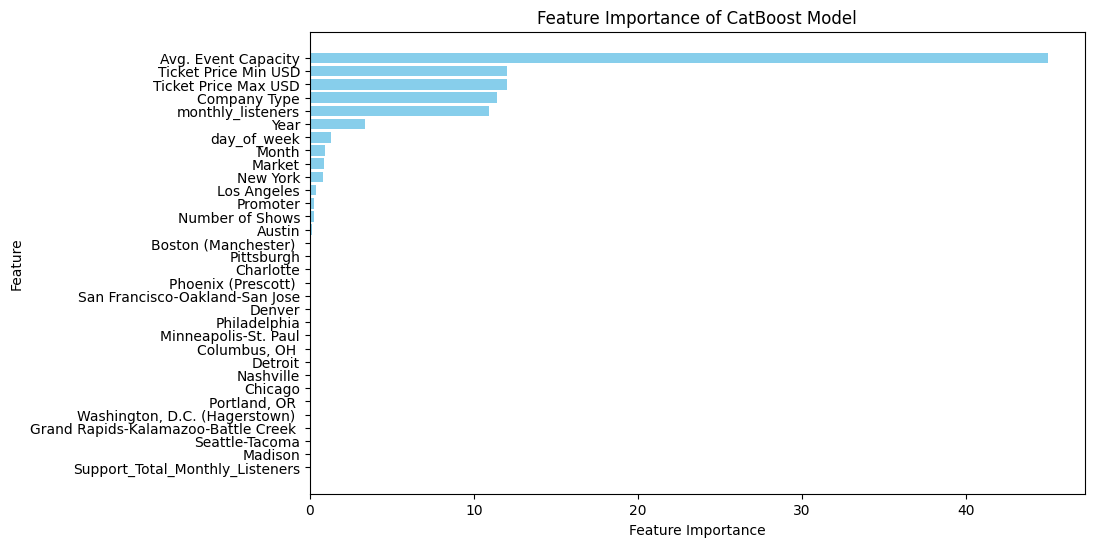

In [23]:
# Map features to their importance
feature_names = features  # Use the same order as in your data
importance_scores = cat_model.feature_importances_

# Sort by importance
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = importance_scores[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

### Repeat with Cross Validation

In [13]:
# Initialize the model
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=['day_of_week', 'Month', 'Company Type', 'Market', 'Promoter'])

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=8)
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    cat_model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = cat_model.predict(X_val)
    
    # Compute metrics
    rmse_scores.append(mean_squared_error(y_val, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    r2_scores.append(r2_score(y_val, y_pred))

# Calculate average metrics
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)

print("CatBoost Regressor K-Fold Cross-Validation Performance:")
print(f"Average RMSE: {avg_rmse}")
print(f"Average MAE: {avg_mae}")
print(f"Average R^2: {avg_r2}")

C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarnin

CatBoost Regressor K-Fold Cross-Validation Performance:
Average RMSE: 0.4253131866286872
Average MAE: 0.30474158587067085
Average R^2: 0.9595119744403453


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### TimeSeries Split

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store results for each split
rmse_scores = []
mae_scores = []
r2_scores = []

# Loop through splits
print("Time-Series Cross-Validation Results:")
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    # Split the data
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    cat_model = CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=['Company Type', 'Market', 'Promoter'])
    cat_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = cat_model.predict(X_val)
    
    # Calculate metrics
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # Append metrics to lists
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    # Print metrics for this split
    print(f"  Split {i + 1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R^2 = {r2:.4f}")

# Calculate and print averages
print("\nAverage Performance Across Splits:")
print(f"  Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"  Average MAE: {np.mean(mae_scores):.4f}")
print(f"  Average R^2: {np.mean(r2_scores):.4f}")


Time-Series Cross-Validation Results:


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 1: RMSE = 0.5342, MAE = 0.3946, R^2 = 0.9183


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 2: RMSE = 0.4398, MAE = 0.3354, R^2 = 0.9471


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 3: RMSE = 0.4681, MAE = 0.3473, R^2 = 0.9506


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


  Split 4: RMSE = 0.4442, MAE = 0.3210, R^2 = 0.9557
  Split 5: RMSE = 0.4340, MAE = 0.3050, R^2 = 0.9590

Average Performance Across Splits:
  Average RMSE: 0.4640
  Average MAE: 0.3406
  Average R^2: 0.9461


C:\Users\sarah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
